#Importing libraries

In [ ]:
import numpy as np
from PIL import Image
import cv2
from random import randint
import json
import base64
import matplotlib.pyplot as plt

#Encryption

###Below is an image encryption based on the Rubik's cube method. Basically, the image method performs a row shift to the right or left, a column shift up or down, and a pixel xor operation with the key.

####roll_rows_enc function moves the row to the right if the row sum is even, and to the left if it is odd. The roll_rows_dec function does the opposite.

In [ ]:
def roll_rows_enc(image):
    row_sums = image.sum(axis=1)

    for i, row_sum in enumerate(row_sums):
        for sum in row_sum:
          if sum % 2 == 0:
              image[i] = np.roll(image[i], image.shape[0]//4)
          else:
              image[i] = np.roll(image[i], -image.shape[0]//4)

    return image

In [ ]:
def roll_rows_dec(image):
    row_sums = image.sum(axis=1)

    for i, row_sum in enumerate(row_sums):
        for sum in row_sum:
          if sum % 2 == 0:
              image[i] = np.roll(image[i], -image.shape[0]//4)
          else:
              image[i] = np.roll(image[i], image.shape[0]//4)

    return image

###roll_cols_enc function moves the column up if the sum of the column is even, and down if it is odd. The roll_cols_dec function does the opposite.

In [ ]:
def roll_cols_enc(image):
    col_sums = image.sum(axis=0)

    for j, col_sum in enumerate(col_sums):
        for sum in col_sum:
          if sum % 2 == 0:
              image[:, j] = np.roll(image[:, j], image.shape[1]//2)
          else:
              image[:, j] = np.roll(image[:, j], -image.shape[1]//2)

    return image

In [ ]:
def roll_cols_dec(image):
    col_sums = image.sum(axis=0)

    for j, col_sum in enumerate(col_sums):
        for sum in col_sum:
          if sum % 2 == 0:
              image[:, j] = np.roll(image[:, j], -image.shape[1]//2)
          else:
              image[:, j] = np.roll(image[:, j], image.shape[1]//2)

    return image

####The xor_rows function performs a pixel xor operation with the generated key for the current row. It is important to note that MxN random keys are generated, i.e. for each row and each column separately.

In [ ]:
def xor_rows(image, keyrow):
    for i in range(image.shape[0]):
        image[i,:,0] = image[i,:,0] ^ keyrow[i]
        image[i,:,1] = image[i,:,1] ^ keyrow[i]
        image[i,:,2] = image[i,:,2] ^ keyrow[i]

    return image

####The xor_cols function performs a pixel xor operation with the generated key for the current column.

In [ ]:
def xor_cols(image, keycol):
    for j in range(image.shape[1]):
        image[:,j,0] = image[:,j,0] ^ keycol[j]
        image[:,j,1] = image[:,j,1] ^ keycol[j]
        image[:,j,2] = image[:,j,2] ^ keycol[j]

    return image

####The main function that generates and stores keys, and calls previous functions to perform image encryption.

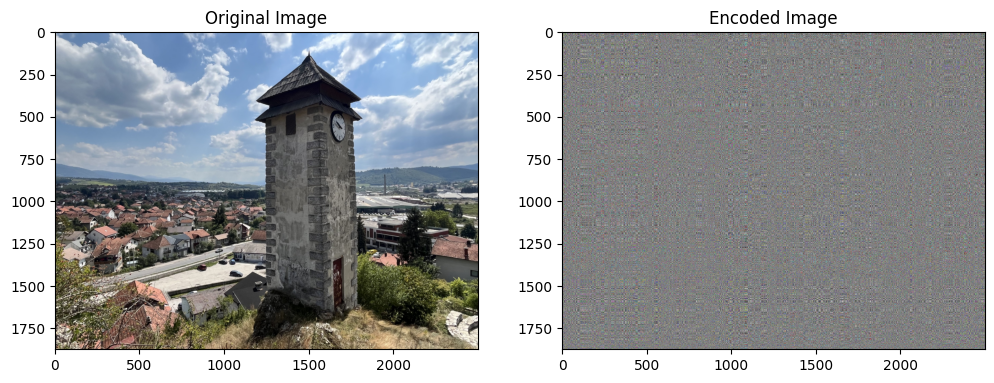

Encryption finished, image saved as encrypted_image.png


In [ ]:
def encrypt_image(image_path, output_path):
    image = Image.open(image_path)
    image = np.array(image)

    keyrow = [randint(0, pow(2,64)-1) for i in range(image.shape[0])]
    keycol = [randint(0, pow(2,64)-1) for i in range(image.shape[1])]

    encoded_key = {
        'keyrow':keyrow,
        'keycol':keycol
    }

    serialized_key_dict = json.dumps(encoded_key)
    encoded_key = base64.b64encode(serialized_key_dict.encode())

    with open('key', "wb") as binary_file:
      binary_file.write(encoded_key)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image)

    image = roll_rows_enc(image)

    image = roll_cols_enc(image)

    image = xor_rows(image, keyrow)

    image = xor_cols(image, keycol)

    encrypted_image = Image.fromarray(image)
    encrypted_image.save(output_path)

    plt.subplot(1, 2, 2)
    plt.title('Encoded Image')
    plt.imshow(image)

    plt.show()

encrypt_image('dv.jpg', 'encrypted_image.png')
print('Encryption finished, image saved as encrypted_image.png')

#Decryption

####The following function performs image decryption using the inverse functions roll_cols_dec and roll_rows_dec, and xor_rows and xor_cols, which do not require an inverse. It is important to note that the order in which functions are called is important, and it must be the opposite of that for encryption.

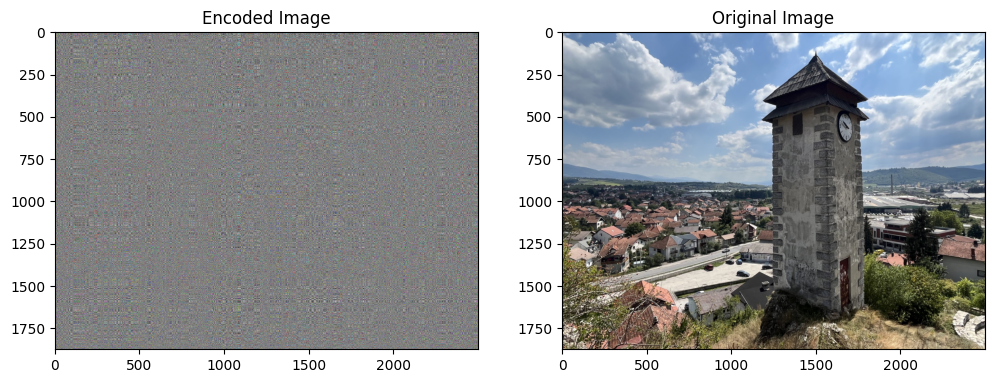

Decryption finished, image saved as decrypted_image.png


In [ ]:
def decrypt_image(encrypted_image_path, output_path):
    with open('key', 'r') as keyfile:
      encoded_key = keyfile.read()
      decoded_key = base64.b64decode(encoded_key).decode()
      decoded_dict = json.loads(decoded_key)
      keyrow = decoded_dict['keyrow']
      keycol = decoded_dict['keycol']

    encrypted_image = Image.open(encrypted_image_path)
    image = np.array(encrypted_image)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Encoded Image')
    plt.imshow(image)

    image = xor_cols(image, keycol)

    image = xor_rows(image, keyrow)

    image = roll_cols_dec(image)

    image = roll_rows_dec(image)

    decrypted_image = Image.fromarray(image.astype(np.uint8))
    decrypted_image.save(output_path)

    plt.subplot(1, 2, 2)
    plt.title('Original Image')
    plt.imshow(image)

    plt.show()

decrypt_image('encrypted_image.png', 'decrypted_image.png')
print('Decryption finished, image saved as decrypted_image.png')

#Rating of the encryption algorithm

####We evaluate the algorithm by counting how many pixels remain in place after encryption, the lower the number, the better the algorithm. We can see below that 99.99% of pixels have changed position.

In [ ]:
original_image_path = 'nedimPortrait.jpg'
original_image = Image.open(original_image_path)
original_image = np.array(original_image)

encrypted_image_path = 'encrypted_image.png'
encrypted_image = Image.open(encrypted_image_path)
encrypted_image = np.array(encrypted_image)

sum=0
for i in range(original_image.shape[0]):
  for j in range(original_image.shape[1]):
    if(original_image[i][j][0] != encrypted_image[i][j][0]
      or original_image[i][j][1] != encrypted_image[i][j][1]
      or original_image[i][j][2] != encrypted_image[i][j][2]):
     sum+=1

num_of_pixels = original_image.shape[0] * original_image.shape[1]
npcr = sum / num_of_pixels
print('Number of pixels change rate: ', npcr*100 , '%')

Number of pixels change rate:  99.99970666469545 %
